In [1]:
import os
import sys
import numpy as np
import collections
import argparse
from numpy import ones, tile
from mcbits import coders, util
from models.toy_model import ToyModel
import random

exp_name = "cleanliness_convergence_plots_toy_mixture"
dir_name = os.path.join('./save', exp_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# Arguments

In [2]:
# toy experiment parameters, use smaller values to get results faster
alphabet_size = 64
latent_alphabet_size = 256
message_length = 2000

# rANS stack parameters
mprec = 16
bprec = 32
lprec = 32

# increase the num of particles or ais steps from [1, 2, ..., 2^log_max]
log_max = 7  

# Toy Model

In [3]:
np.random.seed(1234)
random.seed(1234)

# model
model = ToyModel(latent_alphabet_size, alphabet_size)
ENTROPY = model.entropy

# get message
message = model.sample_message(message_length)

# uniform distribution as posterior
prop_counts = (ones((latent_alphabet_size, alphabet_size))
                   / latent_alphabet_size)

# Count Stat Funcs

In [4]:
prior_count_stat_func_cache = util.Categorical(mprec, model.z_probs, use_make_sum_to_M=True)

def get_prior_count_stat_func():
    return prior_count_stat_func_cache

prop_count_stat_func_cache = {}
def get_prop_count_stat_func(x):
    if x in prop_count_stat_func_cache:
        return prop_count_stat_func_cache[x]
    else:  
        stat_func = util.Categorical(mprec, prop_counts[:, x], use_make_sum_to_M=True)
        prop_count_stat_func_cache[x] = stat_func
        
        return stat_func

cond_count_stat_func_cache = {}
def get_cond_count_stat_func(z): 
    if z in cond_count_stat_func_cache:
        return cond_count_stat_func_cache[z]
    else:
        stat_func = util.Categorical(mprec, model.cond_probs[z], use_make_sum_to_M=True)
        cond_count_stat_func_cache[z] = stat_func
        
        return stat_func
    
joint_count_stat_func_cache_z = {}
joint_count_stat_func_cache_x = {}

def get_joint_count_stat_func(z=None, x=None):
    if z is not None and x is None:
        if z in joint_count_stat_func_cache_z:
            return joint_count_stat_func_cache_z[z]
        else:
            stat_func = util.Categorical(mprec, model.joint_probs[z], use_make_sum_to_M=True)
            joint_count_stat_func_cache_z[z] = stat_func
            
            return stat_func
    elif x is not None and z is None:
        if x in joint_count_stat_func_cache_x:
            return joint_count_stat_func_cache_x[x]
        else:
            stat_func = util.Categorical(mprec, model.joint_probs[:, x], use_make_sum_to_M=True)
            joint_count_stat_func_cache_x[x] = stat_func
            
            return stat_func
    else:
        raise Exception("Bad arg to joint_count_stat_func_fn.")

# BB-ELBO Coder

## Compute compression rate  

In [5]:
coder_class = coders.BitsBackCoder

coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}

ideal_bits_bitsback = model.elbo_code(prop_counts)

coder = coder_class(**coder_kwargs)
coder.encode(message)
true_bits_bitsback = coder.bit_length / message_length
true_net_bits_bitsback = coder.net_bit_length / message_length


print(f"BB")
print(f"\tentropy : {ENTROPY}")
print(f"\tideal bit length : {ideal_bits_bitsback}")
print(f"\ttrue bit length : {true_bits_bitsback}")
print(f"\ttrue net bit length : {true_net_bits_bitsback}")

BB
	entropy : 5.99898138642992
	ideal bit length : 6.332292098705365
	true bit length : 6.660829297178408
	true net bit length : 6.628829297178408


## Save

In [6]:
np.save(os.path.join(dir_name, "entropy"), np.array([ENTROPY]))
np.save(os.path.join(dir_name, "ideal_bits_bitsback"), np.array([ideal_bits_bitsback]))
np.save(os.path.join(dir_name, "true_bits_bitsback"), np.array([true_bits_bitsback]))
np.save(os.path.join(dir_name, "true_net_bits_bitsback"), np.array([true_net_bits_bitsback]))

# BB-AIS Coder

## Compute compression rate vs AIS steps

In [7]:
ais_steps_array = list(2 ** np.arange(log_max+1))
print(ais_steps_array)

[1, 2, 4, 8, 16, 32, 64, 128]


In [8]:
coder_class = coders.AISBitsBackCoder

# adjust coder kwargs for AIS coder
coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "get_joint_count_stat_func": get_joint_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}


ideal_bits_ais_bitsback_array = [] 
true_bits_ais_bitsback_array = []
true_net_bits_ais_bitsback_array = []
true_bits_ais_bitsback_bitswap_array = []
true_net_bits_ais_bitsback_bitswap_array = []

for ais_steps in ais_steps_array:
    coder_kwargs["betas"] = np.flip(np.linspace(0, 1, ais_steps+1))
    ideal_bits_ais_bitsback = model.ais_code(prop_counts, betas=coder_kwargs["betas"])

    coder_kwargs["bitswap"] = False
    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    true_bits_ais_bitsback = coder.bit_length / message_length
    true_net_bits_ais_bitsback = coder.net_bit_length / message_length

    coder_kwargs["bitswap"] = True
    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    true_bits_ais_bitsback_bitswap = coder.bit_length / message_length
    true_net_bits_ais_bitsback_bitswap = coder.net_bit_length / message_length
    
    
    print(f"AIS STEPS={ais_steps}")
    print(f"\tentropy : {ENTROPY}")
    print(f"\tideal bit length : {ideal_bits_ais_bitsback}")
    print(f"\ttrue bit length : {true_bits_ais_bitsback}")
    print(f"\ttrue net bit length : {true_net_bits_ais_bitsback}")
    print(f"\ttrue bit length (bitswap) : {true_bits_ais_bitsback_bitswap}")
    print(f"\ttrue net bit length (bitswap) : {true_net_bits_ais_bitsback_bitswap}")
    

    ideal_bits_ais_bitsback_array.append(ideal_bits_ais_bitsback)
    true_bits_ais_bitsback_array.append(true_bits_ais_bitsback)
    true_net_bits_ais_bitsback_array.append(true_net_bits_ais_bitsback)
    true_bits_ais_bitsback_bitswap_array.append(true_bits_ais_bitsback_bitswap)
    true_net_bits_ais_bitsback_bitswap_array.append(true_net_bits_ais_bitsback_bitswap)
    
ideal_bits_ais_bitsback_array[0] = ideal_bits_bitsback # for consistency

AIS STEPS=1
	entropy : 5.99898138642992
	ideal bit length : 6.345717273236879
	true bit length : 6.660829297178408
	true net bit length : 6.628829297178408
	true bit length (bitswap) : 6.660829297178408
	true net bit length (bitswap) : 6.628829297178408
AIS STEPS=2
	entropy : 5.99898138642992
	ideal bit length : 6.185984582306357
	true bit length : 6.231043452869427
	true net bit length : 6.199043452869427
	true bit length (bitswap) : 6.242775943711777
	true net bit length (bitswap) : 6.210775943711777
AIS STEPS=4
	entropy : 5.99898138642992
	ideal bit length : 6.094263764317175
	true bit length : 6.124027515743999
	true net bit length : 6.092027515743999
	true bit length (bitswap) : 6.13854611916751
	true net bit length (bitswap) : 6.10654611916751
AIS STEPS=8
	entropy : 5.99898138642992
	ideal bit length : 6.048099087866386
	true bit length : 6.088501290354724
	true net bit length : 6.040501290354724
	true bit length (bitswap) : 6.114489336087744
	true net bit length (bitswap) : 6.08

## Save

In [9]:
np.save(os.path.join(dir_name, "ideal_bits_ais_bitsback_array"), np.array(ideal_bits_ais_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_ais_bitsback_array"), np.array(true_bits_ais_bitsback_array))
np.save(os.path.join(dir_name, "true_net_bits_ais_bitsback_array"), np.array(true_net_bits_ais_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_ais_bitsback_bitswap_array"), np.array(true_bits_ais_bitsback_bitswap_array))
np.save(os.path.join(dir_name, "true_net_bits_ais_bitsback_bitswap_array"), np.array(true_net_bits_ais_bitsback_bitswap_array))

# BB-IS Coder

## Compute compression rate vs # particles

In [10]:
num_particles_array = list(2 ** np.arange(log_max+1))
print(num_particles_array)

[1, 2, 4, 8, 16, 32, 64, 128]


In [11]:
coder_class = coders.ISBitsBackCoder

coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}


ideal_bits_is_bitsback_array = [] 
true_bits_is_bitsback_array = []
true_net_bits_is_bitsback_array = []

for num_particles in num_particles_array:
    coder_kwargs["num_particles"] = num_particles
    ideal_bits_is_bitsback = model.is_code(prop_counts, num_particles=num_particles)

    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    true_bits_is_bitsback = coder.bit_length / message_length
    true_net_bits_is_bitsback = coder.net_bit_length / message_length
    
    
    print(f"IS # Particles={num_particles}")
    print(f"\tentropy : {ENTROPY}")
    print(f"\tideal bit length : {ideal_bits_is_bitsback}")
    print(f"\ttrue bit length : {true_bits_is_bitsback}")
    print(f"\ttrue net bit length : {true_net_bits_is_bitsback}")

    ideal_bits_is_bitsback_array.append(ideal_bits_is_bitsback)
    true_bits_is_bitsback_array.append(true_bits_is_bitsback)
    true_net_bits_is_bitsback_array.append(true_net_bits_is_bitsback)
    
ideal_bits_is_bitsback_array[0] = ideal_bits_bitsback  # for consistency

IS # Particles=1
	entropy : 5.99898138642992
	ideal bit length : 6.313123186858758
	true bit length : 6.660829297178408
	true net bit length : 6.628829297178408
IS # Particles=2
	entropy : 5.99898138642992
	ideal bit length : 6.139340167746978
	true bit length : 6.183557768278365
	true net bit length : 6.151557768278365
IS # Particles=4
	entropy : 5.99898138642992
	ideal bit length : 6.060848507071258
	true bit length : 6.121066920157717
	true net bit length : 6.073066920157717
IS # Particles=8
	entropy : 5.99898138642992
	ideal bit length : 6.025293336561421
	true bit length : 6.093365235645762
	true net bit length : 6.029365235645763
IS # Particles=16
	entropy : 5.99898138642992
	ideal bit length : 6.012523459314045
	true bit length : 6.107857410335414
	true net bit length : 6.011857410335414
IS # Particles=32
	entropy : 5.99898138642992
	ideal bit length : 6.0037576402762225
	true bit length : 6.173790751678833
	true net bit length : 6.013790751678834
IS # Particles=64
	entropy : 5.

## Save

In [12]:
np.save(os.path.join(dir_name, "ideal_bits_is_bitsback_array"), np.array(ideal_bits_is_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_is_bitsback_array"), np.array(true_bits_is_bitsback_array))
np.save(os.path.join(dir_name, "true_net_bits_is_bitsback_array"), np.array(true_net_bits_is_bitsback_array))

# BB-CIS Coder

In [13]:
coder_class = coders.CISBitsBackCoder

# for cis, we use shift sampling operators to generate other latents
def shift_sampling(shift, precision):
    assert 0.0 <= shift <= 1.0
    upper = 1 << precision
    shift_scaled = int(shift * upper)

    def operator(u, prop_count_stat_func):
        return (u + shift_scaled) % upper

    def inverse_operator(u, prop_count_stat_func):
        return (u - shift_scaled) % upper

    return (operator, inverse_operator)


coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}


ideal_bits_cis_bitsback_array = [] 
true_bits_cis_bitsback_array = []
true_net_bits_cis_bitsback_array = []

for num_particles in num_particles_array:  
    sampling_shifts = np.random.rand(num_particles-1,)
    sampling_shifts = np.insert(sampling_shifts, 0, 0.0)
    shift_sampling_operators = [shift_sampling(shift, mprec) for shift in sampling_shifts]

    
    ideal_bits_cis_bitsback = model.coupled_is_code(prop_counts, sampling_shifts, num_particles=num_particles)
    
    coder_kwargs["num_particles"] = num_particles
    coder_kwargs["bijective_operators"] = shift_sampling_operators

    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    true_bits_cis_bitsback = coder.bit_length / message_length
    true_net_bits_cis_bitsback = coder.net_bit_length / message_length
    
    
    print(f"CIS # Particles={num_particles}")
    print(f"\tentropy : {ENTROPY}")
    print(f"\tideal bit length : {ideal_bits_cis_bitsback}")
    print(f"\ttrue bit length : {true_bits_cis_bitsback}")
    print(f"\ttrue net bit length : {true_net_bits_cis_bitsback}")

    ideal_bits_cis_bitsback_array.append(ideal_bits_cis_bitsback)
    true_bits_cis_bitsback_array.append(true_bits_cis_bitsback)
    true_net_bits_cis_bitsback_array.append(true_net_bits_cis_bitsback)
    
ideal_bits_cis_bitsback_array[0] = ideal_bits_bitsback # for consistency

CIS # Particles=1
	entropy : 5.99898138642992
	ideal bit length : 6.331864539585919
	true bit length : 6.628824619151356
	true net bit length : 6.596824619151356
CIS # Particles=2
	entropy : 5.99898138642992
	ideal bit length : 6.145967910181865
	true bit length : 6.186715189134724
	true net bit length : 6.154715189134724
CIS # Particles=4
	entropy : 5.99898138642992
	ideal bit length : 6.065314551376397
	true bit length : 6.106364545894613
	true net bit length : 6.074364545894613
CIS # Particles=8
	entropy : 5.99898138642992
	ideal bit length : 6.027942358754108
	true bit length : 6.05516643468244
	true net bit length : 6.02316643468244
CIS # Particles=16
	entropy : 5.99898138642992
	ideal bit length : 6.013738528014056
	true bit length : 6.048421573323136
	true net bit length : 6.016421573323136
CIS # Particles=32
	entropy : 5.99898138642992
	ideal bit length : 6.0048868786647045
	true bit length : 6.035459244605293
	true net bit length : 6.003459244605293
CIS # Particles=64
	entropy

## Save

In [14]:
np.save(os.path.join(dir_name, "ideal_bits_cis_bitsback_array"), np.array(ideal_bits_cis_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_cis_bitsback_array"), np.array(true_bits_cis_bitsback_array))
np.save(os.path.join(dir_name, "true_net_bits_cis_bitsback_array"), np.array(true_net_bits_cis_bitsback_array))

# Load

In [15]:
# BB-ELBO
ENTROPY = np.load(os.path.join(dir_name, "entropy.npy"))[0]
ideal_bits_bitsback = np.load(os.path.join(dir_name, "ideal_bits_bitsback.npy"))[0]
true_bits_bitsback = np.load(os.path.join(dir_name, "true_bits_bitsback.npy"))[0]
true_net_bits_bitsback = np.load(os.path.join(dir_name, "true_net_bits_bitsback.npy"))[0]

# BB-AIS
ideal_bits_ais_bitsback_array = np.load(os.path.join(dir_name, "ideal_bits_ais_bitsback_array.npy"))
true_bits_ais_bitsback_array = np.load(os.path.join(dir_name, "true_bits_ais_bitsback_array.npy"))
true_net_bits_ais_bitsback_array = np.load(os.path.join(dir_name, "true_net_bits_ais_bitsback_array.npy"))
true_bits_ais_bitsback_bitswap_array = np.load(os.path.join(dir_name, "true_bits_ais_bitsback_bitswap_array.npy"))
true_net_bits_ais_bitsback_bitswap_array = np.load(os.path.join(dir_name, "true_net_bits_ais_bitsback_bitswap_array.npy"))

# BB-IS
ideal_bits_is_bitsback_array = np.load(os.path.join(dir_name, "ideal_bits_is_bitsback_array.npy"))
true_bits_is_bitsback_array = np.load(os.path.join(dir_name, "true_bits_is_bitsback_array.npy"))
true_net_bits_is_bitsback_array = np.load(os.path.join(dir_name, "true_net_bits_is_bitsback_array.npy"))

# BB-CIS
ideal_bits_cis_bitsback_array = np.load(os.path.join(dir_name, "ideal_bits_cis_bitsback_array.npy"))
true_bits_cis_bitsback_array = np.load(os.path.join(dir_name, "true_bits_cis_bitsback_array.npy"))
true_net_bits_cis_bitsback_array = np.load(os.path.join(dir_name, "true_net_bits_cis_bitsback_array.npy"))

# Plot

In [16]:
from matplotlib import rc
from matplotlib import pyplot as plt

# rc('text', usetex=True)
# rc('font',**{'size':10, "family" : "serif", "serif" : "Times"})
# rc('text.latex', preamble=r'\usepackage{amsfonts}')
# plt.style.use('default')

In [17]:
plot_max = 8

plot_marker_style = {'marker': 'o', 'markersize': 3}
scatter_marker_style = {'marker': 'x', 's': 60}

## Cleanliness Plot

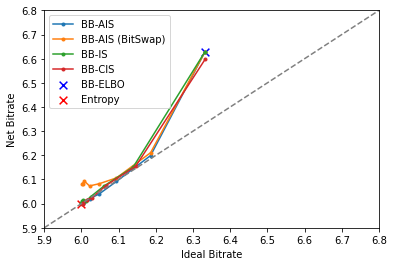

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
bb_ais, = ax.plot(ideal_bits_ais_bitsback_array[:plot_max], true_net_bits_ais_bitsback_array[:plot_max], label=r'BB-AIS', **plot_marker_style)
bb_ais_bitswap, = ax.plot(ideal_bits_ais_bitsback_array[:plot_max], true_net_bits_ais_bitsback_bitswap_array[:plot_max], label=r'BB-AIS (BitSwap)', **plot_marker_style)
bb_is, = ax.plot(ideal_bits_is_bitsback_array[:plot_max], true_net_bits_is_bitsback_array[:plot_max], label=r'BB-IS', **plot_marker_style)
bb_cis, = ax.plot(ideal_bits_cis_bitsback_array[:plot_max], true_net_bits_cis_bitsback_array[:plot_max], label=r'BB-CIS', **plot_marker_style)
bb_elbo = ax.scatter([ideal_bits_bitsback], [true_net_bits_bitsback], label=r'BB-ELBO', c='b', **scatter_marker_style)
bb_ideal = ax.scatter([ENTROPY], [ENTROPY], label=r'Entropy', c='r', **scatter_marker_style)


start = 5.9
end = 6.8
ax.set_xlim([start, end])
ax.set_ylim([start, end])
ax.plot([start, end], [start, end], ls='--', c='gray')
ax.legend()
ax.set_xlabel(r'Ideal Bitrate')
ax.set_ylabel(r'Net Bitrate')

plt.show()

## Convergence Plot

/scratch/ssd002/home/ryoungj/conda_envs/mcbits_test/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  if sys.path[0] == '':


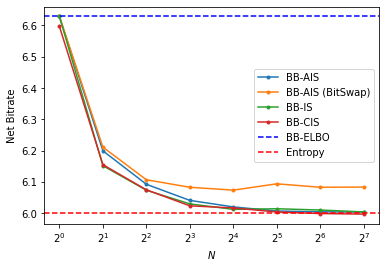

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
bb_ais, = ax.plot(ais_steps_array[:plot_max], true_net_bits_ais_bitsback_array[:plot_max], label=r'BB-AIS', **plot_marker_style)
bb_ais_bitswap, = ax.plot(ais_steps_array[:plot_max], true_net_bits_ais_bitsback_bitswap_array[:plot_max], label=r'BB-AIS (BitSwap)', **plot_marker_style)
bb_is, = ax.plot(num_particles_array[:plot_max], true_net_bits_is_bitsback_array[:plot_max], label=r'BB-IS', **plot_marker_style)
bb_cis, = ax.plot(num_particles_array[:plot_max], true_net_bits_cis_bitsback_array[:plot_max], label=r'BB-CIS', **plot_marker_style)
bb_elbo = ax.axhline(true_net_bits_bitsback, label=r'BB-ELBO', c='b', ls='--')
bb_ideal = ax.axhline(ENTROPY, label=r'Entropy', c='r', ls='--')

ax.legend(frameon=True)
ax.set_xlabel(r'$N$')
ax.set_ylabel('Net Bitrate')
ax.set_xscale('log', basex=2)
plt.legend()

plt.show()